## Calculate linear interpolation between subsequent ALOS-2 image dates

In [7]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Declare data and output directories here
WRKDIR2 = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/'
SPK = WRKDIR2 + 'ALOS2/Congo/Outputs/SPK_nc/'
ALOS_OUT = WRKDIR2 + 'ALOS_nc3/'

env: HDF5_USE_FILE_LOCKING=FALSE


### Inputs

In [8]:
# landtype map
lt_map = xr.open_dataset(ALOS_OUT + 'landtype_100m.nc')

# HH scenes - non masked 
HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_area2.nc')

# only terra firme
HH_db_100m_tf = HH_db_100m.where(lt_map['type'].isin([3]))

# the original HH data masked only for permanent water bodies and non-peat
HH_db_100m_all = xr.open_dataset(ALOS_OUT + 'HH_db_100m_masked_l.nc')


# non-peat pixels and permanent water bodies are masked (output from Peatland_PW_correlation.ipynb)
#HH_db_100m = xr.open_dataset(ALOS_OUT + 'HH_db_100m_masked_l.nc')
#HH_db_100m['db'][0][::5,::5].plot(vmin=-12, vmax=0)

### Identifying seasonally flooded terre firme pixels - useful for follow on study across the full Cuvette Centrale

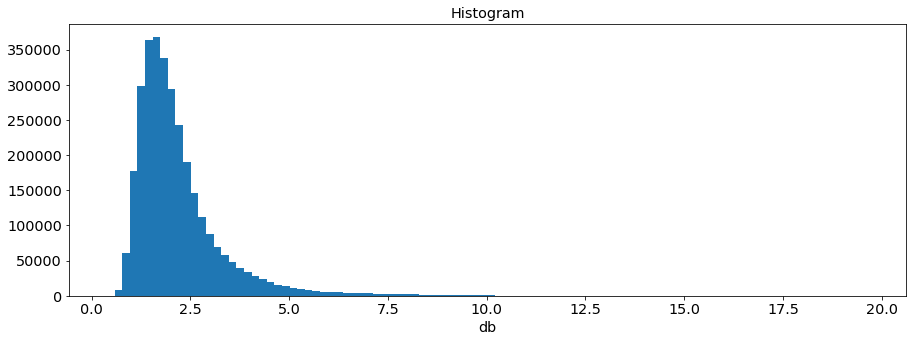

In [42]:
HH_min = HH_db_100m_tf['db'].min(dim='time')
HH_max = HH_db_100m_tf['db'].max(dim='time')

# masking for permanent water bodies that weren't identified in the landtype map
HH_db_100m_tf = HH_db_100m_tf.where(HH_min > -11)

# there are some pixels within -inf values, so filtering for those
HH_min = HH_min.where(HH_min > -20, np.nan)
HH_max = HH_max.where(HH_max > -20, np.nan)

# HH_diff is the difference between the maximum and minimum backscatter for each pixel over the study period. 
HH_diff = HH_max - HH_min
HH_diff.plot.hist(bins=100);

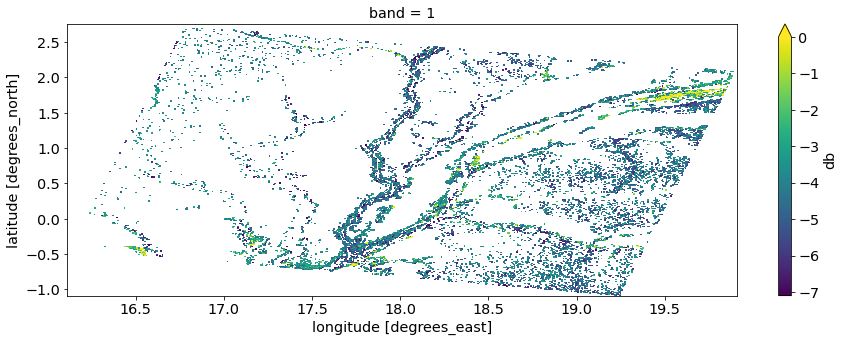

In [44]:
## Seasonally flooded terre firme - mostly bordering rivers, and also in the DRC floodplains
# 7.1 db is the backscatter when the water level is at the soil surface (taking the value from the peatland transfer function derivation)
HH_max = HH_max.where(HH_max > -7.1, np.nan)

# HH_diff is the difference between the maximum and minimum backscatter for each pixel over the study period. Defining a threshold of 3 db for this, which is equivalent
# to a pixel receiving ~24 cm increase in water level. Different thresholds could be tried - . 
HH_si = HH_max.where(HH_diff >3, np.nan)
HH_si[::5,::5].plot(vmax=0, cmap='viridis')

## Main code

In [ ]:
# Defining datetime series for the current set of ALOS-2 images

# array of alos2 scene dates within area 2 (the main area for which we have data)
all_dates = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09','2021-10-08','2021-11-19']

# converting to the datetime format required for dataframes
all_dates = pd.to_datetime(all_dates)
print ('Original radar image dates:\n', all_dates,'\n')


# daily all dates
start_date = all_dates[0]
end_date = all_dates[14]
print ('Start and end dates: \n',start_date,end_date,'\n')

all_dates1 = pd.date_range(start_date,end_date-timedelta(days=1),freq='d')
print ('Daily interpolated radar image dates:\n', all_dates1)


### Linearly interpolating the HH data for non-rainfed peatland and terre firme locations

In [ ]:
%%time
# Linear interpolation
#all_dates1[476:561]   # for HH images 12 to 15 subset

# Linear interpolation for peat pixels only (this is used in the inundation map paper)
ds = HH_db_100m_all

print ("interpolating to daily... ")
HH_linear = ds.interp(time=all_dates1)

print ("saving to file...")

# The peat only version
HH_linear.to_netcdf(ALOS_OUT + 'HH_linear_full_ts.nc')


# linear interpolation over all pixels - for use in full CC mapping when a seasonally inundated map has been finalised
#ds = HH_db_100m_tf
#HH_linear.to_netcdf(ALOS_OUT + 'HH_linear_ts_terrefirme.nc')
